/fh/fast/subramaniam_a/user/rasi/virtualenv/default2/local/lib/python2.7/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/fh/fast/subramaniam_a/user/rasi/virtualenv/default2/local/lib/python2.7/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


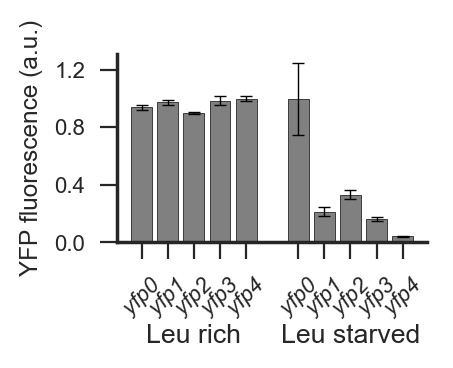

In [1]:
'''Create plot for fig1b from raw data
'''
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from scipy.stats import tsem
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')

od_background = 0.042  # based on well with just growth medium
yfp_background = 40  # based on well with just growth medium


def reorder_mutants(pauselocation):
    if pd.isnull(pauselocation):
        return tuple([0])
    else:
        pauselocation = sorted([int(pos) for pos in pauselocation.split(',')])
        return tuple([len(pauselocation)] + pauselocation)


# read in raw data for each well and corresponding annotations and merge
rawdata = pd.read_table('../rawdata/platereader/fig1_fluorescence_data.tsv')
annotations = pd.read_table(
    '../rawdata/platereader/fig1_fluorescence_annotations.tsv')
rawdata = rawdata.merge(annotations, on=['plate', 'well'], how='inner')
data = rawdata

# normalize yfp by od
data['od'] = data['od'] - od_background
data['yfp'] = data['yfp'] - yfp_background
data['yfp/od'] = data['yfp'] / data['od']

# groupby label without considering replicate
groupedReplicates = data.groupby('strain_label')
average = groupedReplicates[['yfp/od']].agg(np.mean).rename(
    columns={'yfp/od': 'mean'})
error = groupedReplicates[['yfp/od']].agg(tsem).rename(
    columns={'yfp/od': 'err'})
annotations = data.drop(
    ['yfp/od', 'yfp', 'od', 'time', 'replicate'],
    axis=1).groupby('strain_label').first()
averagedData = pd.concat([average, error, annotations], join='inner', axis=1)

normalization = averagedData.groupby('medium')['mean'].transform(
    lambda x: x.max())

averagedData['mean'] /= normalization
averagedData['err'] /= normalization

# exclude the no-induction control
averagedData = averagedData[averagedData['induction'] == '+atc']

# reorder samples: rich first, increasing number and location of pause sites
averagedData['sortcolumn'] = averagedData['pauselocation'].apply(
    reorder_mutants)
averagedData = averagedData.sort_values(by=['medium', 'sortcolumn'])

# plot fig.1B
fig = plt.figure()
fig.clf()
ax = fig.add_subplot(1, 1, 1)
# leave space between rich and starved samples
x = range(0, len(averagedData) / 2) + range(
    len(averagedData) / 2 + 1, len(averagedData) + 1)
y = averagedData['mean']
err = averagedData['err']
ticklabels = ['yfp{0}'.format(n) for n in range(5)] * 2
ax.bar(x, y, facecolor='grey', edgecolor='black')
ax.errorbar(
    x,
    y,
    err,
    elinewidth=0.5,
    color='black',
    capsize=2,
    capthick=0.5,
    linestyle='None')
sns.despine()
ax.set(ylabel='YFP fluorescence (a.u.)')
ax.text(2, -0.7, 'Leu rich', ha='center')
ax.text(8, -0.7, 'Leu starved', ha='center')
ax.set_xticks(x)
ax.set_yticks(np.arange(0, 1.25, 0.4))
ax.set_xticklabels(
    ticklabels, rotation=45, ha='center', va='top', fontstyle='italic')
sns.despine()
fig.set_size_inches([2, 1.25])
fig.savefig('../figures/fig1b.svg')